#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision`.

`torchvision` — это библиотека, которая для работы с изображениями и видео. Включает:

- датасеты
- преобразования (изменение размера, обрезку, нормализацию и кучу других)
- предобученные модели (рассмотрим на следующем занятии)
- инструменты для визуализации


`torchvision`` включает в себя популярные датасеты: MNIST, CIFAR, ImageNet...

Базово большинство датасетов создаются одинаково: находите нужный класс и создаете объект. При создании (обычно):

- root: путь к каталогу, где будут храниться загружаемые данные.
- train: указывает, загружать ли обучающую (True) или тестовую (False) выборку (датасеты часто уже разбиты за вас).
- download: Указывает, нужно ли загружать данные, если они еще не сохранены.

In [1]:
import torchvision

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Это готовый датасет, который можно передать в DataLoader и получать батчи, но нужно смотреть, что вы загрузили. Если это не тензоры, то как минимум надо их сначала довести до тензоров

In [2]:
# type(trainset[0][0])

In [3]:
# trainset[0][0]

`torchvision.transforms` — это модуль в библиотеке `torchvision`, который предоставляет множество инструментов для предобработки и аугментации изображений. Он позволяет изменять размер, обрезать, поворачивать, нормализовать и многое другое

Зачем нужно:
- довести до состояния, которое можно передавать в модель 
- аугментировать датасет (аугментация данных помогает модели лучше справляться с различными изменениями в данных, такими как различные углы поворота, освещение и другие факторы)

Идейно это соответствует тому, как мы с вами делали transformы в начале курса. Т.е. датасет создаем как есть, а при получении примера применяем какие-то преобразования.

In [4]:
# import torchvision.transforms as T

# # Определяем последовательность преобразований для изображений
# transform = T.Compose(
#     [
#         T.ToTensor(),  # Преобразует PIL-изображение или в тензор
#         T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализует тензор: (значение - среднее) / стандартное отклонение
#     ]
# )


# # Загружаем датасет CIFAR-10
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

In [5]:
# type(trainset[0][0])

В `torchvision` существуют две версии модуля transforms: v1 и v1. v2 включает в себя улучшения и новые функции.

Коротко:
- v2 предлагает более гибкие и мощные преобразования
- v2 может работать быстрее
- v2 немного меняет интерфейс относительно v1

Для базовых преобразований можно использовать любой вариант, v1 пока не deprecated. Но лучше сразу привыкать к v2. Многие туториалы и LLM покажут вам версию v1, будьте внимательней.

In [6]:
# import torchvision.transforms.v2 as T
# import torch 

# # Определяем последовательность преобразований для изображений
# transform = T.Compose(
#     [
#         T.PILToTensor(),
#         T.ToDtype(torch.float32, scale=True),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )


# # Загружаем датасет CIFAR-10
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

In [7]:
# type(trainset[0][0])

2\. Рассмотрите примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений. Реализуйте типовую архитектуру CNN для классификации изображений.

Простейшие сверточные сети для обработки изображений собираются из:

- собственно, слоя свертки `nn.Conv2d`
- слоя пулинга (`nn.MaxPool2d`, `nn.AvgPool2d`, `nn.AdaptiveAvgPool2d`, `nn.AdaptiveMaxPool2d`)

Дополнительно можно использовать:
- пакетную нормализацию `nn.BatchNorm2d` - вычисляет среднее и стандартное отклонение для каждого канала по всем изображениям в батче
- дропаут (`nn.Dropout2d`) - в отличие от обычного Dropout, который отключает нейроны независимо, Dropout2d отключает целые каналы (или фильтры) в выходах 2D-слоев.

Типовая схема:

- Слой свертки, который извлекает признаки из входных данных
- Слой пакетной нормализации, который нормализует выходы сверточного слоя (может помочь улучшить сходимость модели)
- Функция нелинейности
- Пулинг, который уменьшает размерность выходных данных.
- Дропаут

Часто эти блоки объединяют в отдельный небольшой модуль и собирают модель из них (таким образом повышается уровень абстракции)


In [8]:
# import torch.nn as nn
# import torch.nn.functional as F


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # conv -> bn -> relu -> pooling -> dropout
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.bn1 = nn.BatchNorm2d(num_features=6)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         return x


# net = ConvNet()

# x = trainset[0][0].unsqueeze(0)
# y = net(x)
# y.shape

Прогнали через свертки - как теперь это использовать для прогнозов (например, классификации)

Вариант 1. "Разворачивание" (flattening) выходов из сверточных слоев в одномерный вектор, который затем подается на полносвязный (fully connected) слой. Нормальный простой вариант, если размерность выходных данных фиксирована.



In [9]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Classfier1(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # conv -> bn -> relu -> pooling -> dropout
#         self.feature_extractor = ConvNet() 
#         self.classifier = nn.Linear(16*5*5, 2) 
#         # Вопрос: откуда взять это число?
#         # Вариант 1: применить feature_extractor и посмотреть shape выхода
#         # Вариант 2: посчитать аналитически (это можно вывести на основе архитектуры)
#         # Вариант 3: не считать и использовать LazyLinear, который при первом вызове forward инициализуется нужным кол-вом in_features 
#         #   риски: концепт Lazy-модулей относительно новый, может быть чуть медленнее или проблемнее обычных в каких-то ситуациях
#         # self.classifier = nn.LazyLinear(2) 
        
#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = x.flatten(start_dim=1)
#         x = self.classifier(x)
#         return x


# net = Classfier1()

# x = trainset[0][0].unsqueeze(0)
# y = net(x)
# y.shape

Вариант 2. Вместо простого разворачивания сначала использовать слои типа `nn.AdaptiveAvgPool2d` для приведения выхода к нужному размеру. Может быть удобно, если размер входов может меняться. Потом все равно придется сделать что-то типа `flatten` для передачи в часть-классификатор, но размерность контролируете вы при помощи слоя пулинга.

In [10]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Classfier2(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # conv -> bn -> relu -> pooling -> dropout
#         self.feature_extractor = ConvNet() 
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.classifier = nn.Linear(16, 2) 

        
#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = self.pool(x)
#         x = x.flatten(start_dim=1)
#         x = self.classifier(x)
#         return x


# net = Classfier2()

# x = trainset[0][0].unsqueeze(0)
# y = net(x)
# y.shape

После создания модели - стандартный цикл обучения, там ничего нового.

## Задачи для самостоятельного решения

In [33]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint,EarlyStopping 
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as T
from sklearn.model_selection import train_test_split
import zipfile
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
import pandas as pd

OUT_DIR = Path("artifacts")
OUT_DIR.mkdir(parents=True, exist_ok=True)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<p class="task" id="1"></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. 

При расчете статистики для нормализации считайте, что вы можете загрузить весь набор данных в память сразу. Однако рекомендуется реализовать подход для получения статистики на основе батчей, так как такое решение в перспективе может позволить обработать датасет, который не помещается в память целиком.

- [ ] Проверено на семинаре

In [ ]:
class CatBreedsDataModule(pl.LightningDataModule):
    def __init__(self, data_path: str, zip_path: str, batch_size: int = 64, num_workers: int = 7, random_state = None):
        super().__init__()
        self.data_path = data_path
        self.zip_path = zip_path
        self.batch_size = batch_size
        self.transform = None
        self.train_dataset = None
        self.test_dataset = None
        self.class_names = None
        self.num_classes = 0
        self.num_workers = num_workers
        self.random_state = random_state

    def prepare_data(self):
        if not os.path.exists(self.data_path):
            print(f"Распаковка архива {self.zip_path}...")
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall('.')
            print("Архив успешно распакован.")
        else:
            print(f"Директория {self.data_path} уже существует.")

    def setup(self, stage: str = None):
        # 1. Предварительная трансформация для расчета статистики
        pre_transform = T.Compose([
            T.Resize((300, 300)),
            T.ToImage(),  
            T.ToDtype(torch.float32, scale=True) # Теперь работает с тензором
        ])
        
        full_dataset_for_stats = ImageFolder(root=self.data_path, transform=pre_transform)
        
        # # 2. Разбиение на train/test
        # train_size = int(0.8 * len(full_dataset_for_stats))
        # test_size = len(full_dataset_for_stats) - train_size
        # generator = torch.Generator().manual_seed(42)
        # train_subset_for_stats, _ = random_split(full_dataset_for_stats, [train_size, test_size], generator=generator)

        # 3. Расчет статистики по обучающей выборке
        print("\nРасчет статистики для нормализации...")
        loader = DataLoader(full_dataset_for_stats, batch_size=self.batch_size,)
        
        mean = torch.zeros(3)
        std = torch.zeros(3)
        nb_samples = 0
        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            nb_samples += batch_samples
        
        mean /= nb_samples
        std /= nb_samples
        print(f"Рассчитанное среднее (mean): {mean}")
        print(f"Рассчитанное стандартное отклонение (std): {std}")

        #4. Финальная трансформация с нормализацией
        self.transform = T.Compose([
            T.Resize((128, 128)),
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=mean, std=std)
        ])
            # Трансформации для ОБУЧАЮЩЕГО набора данных (с аугментацией)
        

            
        self.train_transform1 = T.Compose([
            T.Resize((128, 128)),
            T.RandomHorizontalFlip(p=0.5), # Случайное горизонтальное отражение
            T.RandomRotation(degrees=15), # Случайный поворот на 15 градусов
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Случайное изменение яркости/контраста
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=mean, std=std)
        ])
        
        self.train_transform2 = T.Compose([
            # RandomResizedCrop заставляет модель смотреть на детали, а не только на общую форму
            T.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=15),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=mean, std=std)
        ])

        # Трансформации для ТЕСТОВОГО набора (без аугментации!)
        self.test_transform = T.Compose([
            T.Resize((128, 128)),
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=mean, std=std)
        ])
        
        
        
        self.std = std
        self.mean = mean
        # 5. Создание финальных датасетов с разными трансформациями
        dataset_train1 = ImageFolder(root=self.data_path, transform=self.train_transform1)
        dataset_train2 = ImageFolder(root=self.data_path, transform=self.train_transform2)
        dataset_train3 = ImageFolder(root=self.data_path, transform=self.test_transform)
        dataset_test = ImageFolder(root=self.data_path, transform=self.test_transform)
        
        self.class_names = dataset_train1.classes
        self.num_classes = len(self.class_names)
        
        
        
        # Важно! Мы должны разделить один и тот же "исходный" датасет
        # random_split не может работать с двумя разными объектами датасетов
        full_dataset_final = ImageFolder(root=self.data_path) # Без трансформаций
        train_size = int(0.8 * len(full_dataset_final))
        test_size = len(full_dataset_final) - train_size
        self.dataset = full_dataset_final
        
        generator = torch.Generator().manual_seed(42)
        # train_indices, test_indices = random_split(range(len(full_dataset_final)), [train_size, test_size], generator=generator)
        if self.random_state==None:
            rs = np.random.randint(0,1000)
        else:
            rs = self.random_state
        train_indices, test_indices = train_test_split(range(len(full_dataset_final)), stratify=full_dataset_final.targets, test_size=0.2, random_state=rs)
        print(rs)

        
        # Теперь применяем нужные трансформации к нужным подвыборкам
        # self.train_dataset = torch.utils.data.Subset(dataset_train, train_indices.indices)
        # self.test_dataset = torch.utils.data.Subset(dataset_test, test_indices.indices)
        subset1 = Subset(dataset_train1, train_indices)
        subset2= Subset(dataset_train2, train_indices)
        subset3 = Subset(dataset_train3, train_indices)
        
        self.train_dataset =  ConcatDataset([subset1, subset2, subset3])

        self.test_dataset = Subset(dataset_test, test_indices)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return self.test_dataloader()

In [37]:
zip_path = 'cat_breeds_4.zip'
data_path = 'cat_breeds_4'
dm = CatBreedsDataModule(data_path=data_path, zip_path=zip_path, batch_size=64)

dm.prepare_data()
dm.setup()


print(f"Размер обучающей выборки: {len(dm.train_dataset)}")
print(f"Размер тестовой выборки: {len(dm.test_dataset)}")

image_sample, _ = dm.train_dataset[0]


print(f"\nОбщее количество картинок в датасете: {len(dm.train_dataset) + len(dm.test_dataset)}")
print(f"Размер одной картинки (тензора): {image_sample.shape}")
print(f"Количество уникальных классов: {dm.num_classes}")
print("Названия классов:", dm.class_names)

Директория cat_breeds_4 уже существует.

Расчет статистики для нормализации...
Рассчитанное среднее (mean): tensor([0.5000, 0.4514, 0.4066])
Рассчитанное стандартное отклонение (std): tensor([0.2324, 0.2273, 0.2228])
987
Размер обучающей выборки: 9600
Размер тестовой выборки: 800

Общее количество картинок в датасете: 10400
Размер одной картинки (тензора): torch.Size([3, 128, 128])
Количество уникальных классов: 4
Названия классов: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']


<p class="task" id="2"></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

In [14]:
class SimpleClassifier(pl.LightningModule):
    def __init__(self, input_size, num_classes, learning_rate=1e-3, class_weights=None):
        super().__init__()
        self.save_hyperparameters()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, num_classes)
        )

        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss(weight=self.hparams.class_weights)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.train_acc(logits, y)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.test_acc(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)

    def configure_optimizers(self):
        # Оптимизатор использует learning_rate, сохраненный в self.hparams
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [31]:
def show_lossacc(model, annotate=True):
    """
    Строит графики потерь и точности на основе логов из CSVLogger,
    добавляя аннотации к каждой точке.
    """
    # Убеждаемся, что у модели есть логгер
    if model.logger is None:
        print("Logger не найден. Убедитесь, что вы передали logger в Trainer.")
        return

    log_file = f"{model.logger.log_dir}/metrics.csv"
    
    try:
        metrics_df = pd.read_csv(log_file)
    except FileNotFoundError:
        print(f"Файл логов не найден по пути: {log_file}")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20), dpi=400)

    # Убираем строки, где метрика не была записана (NaN)
    train_loss_data = metrics_df[['epoch', 'train_loss']].dropna()
    val_loss_data = metrics_df[['epoch', 'val_loss']].dropna()

    train_acc_data = metrics_df[['epoch', 'train_acc']].dropna()
    val_acc_data = metrics_df[['epoch', 'val_acc']].dropna()

    # График функции потерь
    ax1.plot(train_loss_data['epoch'], train_loss_data['train_loss'], 'o-', label='Training Loss')
    ax1.plot(val_loss_data['epoch'], val_loss_data['val_loss'], 'o-', label='Validation Loss')

    ax1.set_title('Изменение функции потерь на обучающем множестве')
    ax1.set_xlabel('Эпохи')
    ax1.set_ylabel('Loss')

    if annotate:
        # Добавляем аннотации для графика потерь
        for index, row in train_loss_data.iterrows():
            ax1.annotate(f"{row['train_loss']:.3f}", 
                        (row['epoch'], row['train_loss']),
                        textcoords="offset points",
                        xytext=(0, 8), # Смещение текста на 8 пунктов вверх
                        ha='center') # Горизонтальное выравнивание по центру
        for index, row in val_loss_data.iterrows():
            ax1.annotate(f"{row['val_loss']:.3f}", 
                        (row['epoch'], row['val_loss']),
                        textcoords="offset points",
                        xytext=(0, 8), # Смещение текста на 8 пунктов вверх
                        ha='center') # Горизонтальное выравнивание по центру

    ax1.legend()

    # График метрики accuracy
    ax2.plot(train_acc_data['epoch'], train_acc_data['train_acc'], 'o-', label='Training Accuracy')
    ax2.plot(val_acc_data['epoch'], val_acc_data['val_acc'], 'o-', label='Validation Accuracy')
    ax2.set_title('Изменение метрики Accuracy')
    ax2.set_xlabel('Эпохи')
    ax2.set_ylabel('Accuracy')
    
    if annotate:
        

        # Добавляем аннотации для training accuracy
        for index, row in train_acc_data.iterrows():
            ax2.annotate(f"{row['train_acc']:.3f}", 
                        (row['epoch'], row['train_acc']),
                        textcoords="offset points",
                        xytext=(0, 8),
                        ha='center')

        # Добавляем аннотации для validation accuracy
        for index, row in val_acc_data.iterrows():
            ax2.annotate(f"{row['val_acc']:.3f}", 
                        (row['epoch'], row['val_acc']),
                        textcoords="offset points",
                        xytext=(0, -15), # Смещение текста на 15 пунктов вниз, чтобы не пересекаться
                        ha='center',
                        color='orange')

    ax2.legend()

    plt.show()

In [16]:
input_size = reduce(lambda x,y: x*y, image_sample.shape)
MAX_EPOCHS = 30


weights = torch.tensor([0.25, 0.25, 0.25, 0.25], dtype=torch.float).to(device)
# Инициализация модели
model = SimpleClassifier(input_size=input_size, num_classes=dm.num_classes, class_weights=weights, learning_rate=0.003)

# Подсчет количества параметров
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров в модели: {total_params:,}")

# Обучение
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator="auto") #, callbacks=[TQDMProgressBar(refresh_rate=10)])
trainer.fit(model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.test_dataloader())

show_lossacc(model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_mat

Количество обучаемых параметров в модели: 25,339,076


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

c:\Projects\FU\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<p class="task" id="3"></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

In [16]:
def show_examples(model, dataset, class_names, mean=0, std=1, k=6):
    """
    Выводит на экран k случайных примеров из датасета с предсказаниями модели.
    
    Args:
        model: Обученная модель PyTorch.
        dataset: Набор данных PyTorch.
        class_names (list): Список названий классов.
        mean (torch.Tensor): Средние значения для денормализации.
        std (torch.Tensor): Стандартные отклонения для денормализации.
        k (int): Количество примеров для отображения.
    """
    model.eval()
    
    rows = (k + 2) // 3
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()

    indices = random.sample(range(len(dataset)), k)
    
    std_tensor = torch.tensor(std).view(3, 1, 1)
    mean_tensor = torch.tensor(mean).view(3, 1, 1)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label_idx = dataset[idx]
            
            logits = model(image.unsqueeze(0))
            pred_idx = torch.argmax(logits, dim=1).item()
            
            image_unnormalized = image * std_tensor + mean_tensor
            
            image_to_show = image_unnormalized.permute(1, 2, 0).numpy()
            
            image_to_show = np.clip(image_to_show, 0, 1)

            true_class = class_names[label_idx]
            pred_class = class_names[pred_idx]
            
            ax = axes[i]
            ax.imshow(image_to_show)
            ax.set_title(f"Правильный: {true_class}\nПредсказанный: {pred_class}", 
                         color="green" if true_class == pred_class else "red")
            ax.axis('off')
            
    for i in range(k, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()




Примеры предсказаний модели на случайных изображениях из тестового набора:


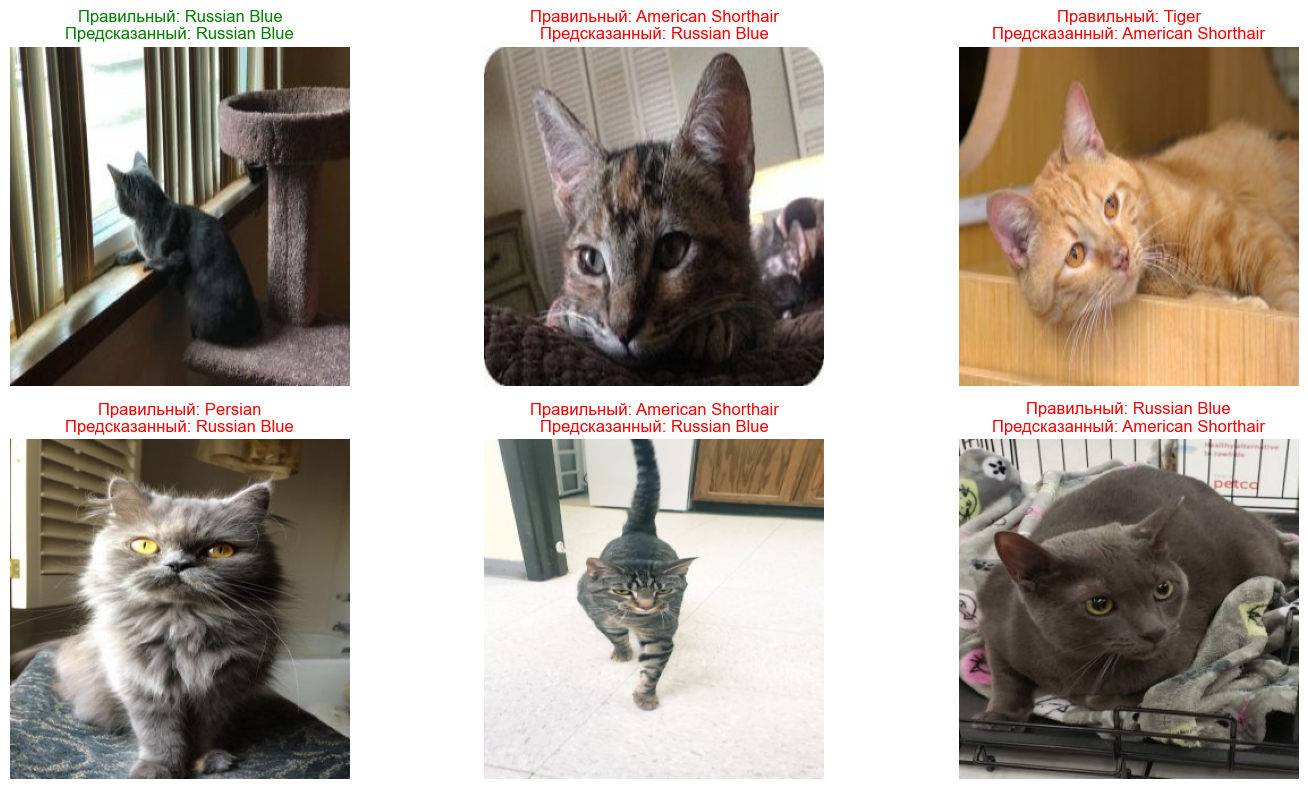

In [ ]:
mean_val = None
std_val = None
for transform in dm.transform.transforms:
    if isinstance(transform, T.Normalize):
        mean_val = transform.mean
        std_val = transform.std
        break

if mean_val is None or std_val is None:
    raise ValueError("Не удалось найти статистику нормализации в dm.transform")
    
print("Примеры предсказаний модели на случайных изображениях из тестового набора:")
show_examples(model, dm.test_dataset, dm.class_names, mean=mean_val, std=std_val, k=6)

<p class="task" id="4"></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

Сохраните веса обученной модели на диск.

- [ ] Проверено на семинаре

In [78]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, class_weights=None):
        super().__init__()
        self.save_hyperparameters()

        # Блок извлечения признаков (только свертки)
        self.feature_extractor = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 4 (добавим для размера 300х300)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Классификатор
        self.classifier = nn.Sequential(
            # Усредняем все пространственные размеры в 1x1 (AdaptiveAvgPool)
            # Это позволяет подавать картинки любого размера и уменьшает кол-во параметров
            nn.AdaptiveAvgPool2d((2, 2)), 
            nn.Flatten(),
            
            # Полносвязная часть
            nn.Linear(256*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Увеличим Dropout до 0.5 для борьбы с переобучением
            nn.Linear(512, num_classes)
        )
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss(weight=self.hparams.class_weights)
        
        # Метрики (оставляем как у вас)
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.test_acc(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)

    def configure_optimizers(self):
        # SGD с Momentum — классика для сверточных сетей
        optimizer = torch.optim.SGD(
            self.parameters(), 
            lr=self.learning_rate,            # Для SGD нужен LR побольше, чем для Adam (начните с 0.01)
            momentum=0.9,       # Обязательно
            weight_decay=5e-4   # Чуть сильнее регуляризация
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5 #, verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",
            },
        }

Директория cat_breeds_4 уже существует.

Расчет статистики для нормализации...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Projects\FU\Course_3\DL\artifacts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | feature_extractor | Sequential         | 389 K  | train
1 | classifier        | Sequential         | 526 K  | train
2 | criterion         | CrossEntropyLoss   | 0      | train
3 | train_acc         | MulticlassAccuracy | 0      | train
4 | val_acc           | MulticlassAccuracy | 0      | train
5 | test_acc          | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
916 K     Trainable params
0         Non-trainable params
916 K     Total params
3.665     Total estimated model p

Рассчитанное среднее (mean): tensor([0.5000, 0.4514, 0.4066])
Рассчитанное стандартное отклонение (std): tensor([0.2324, 0.2273, 0.2228])
661


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


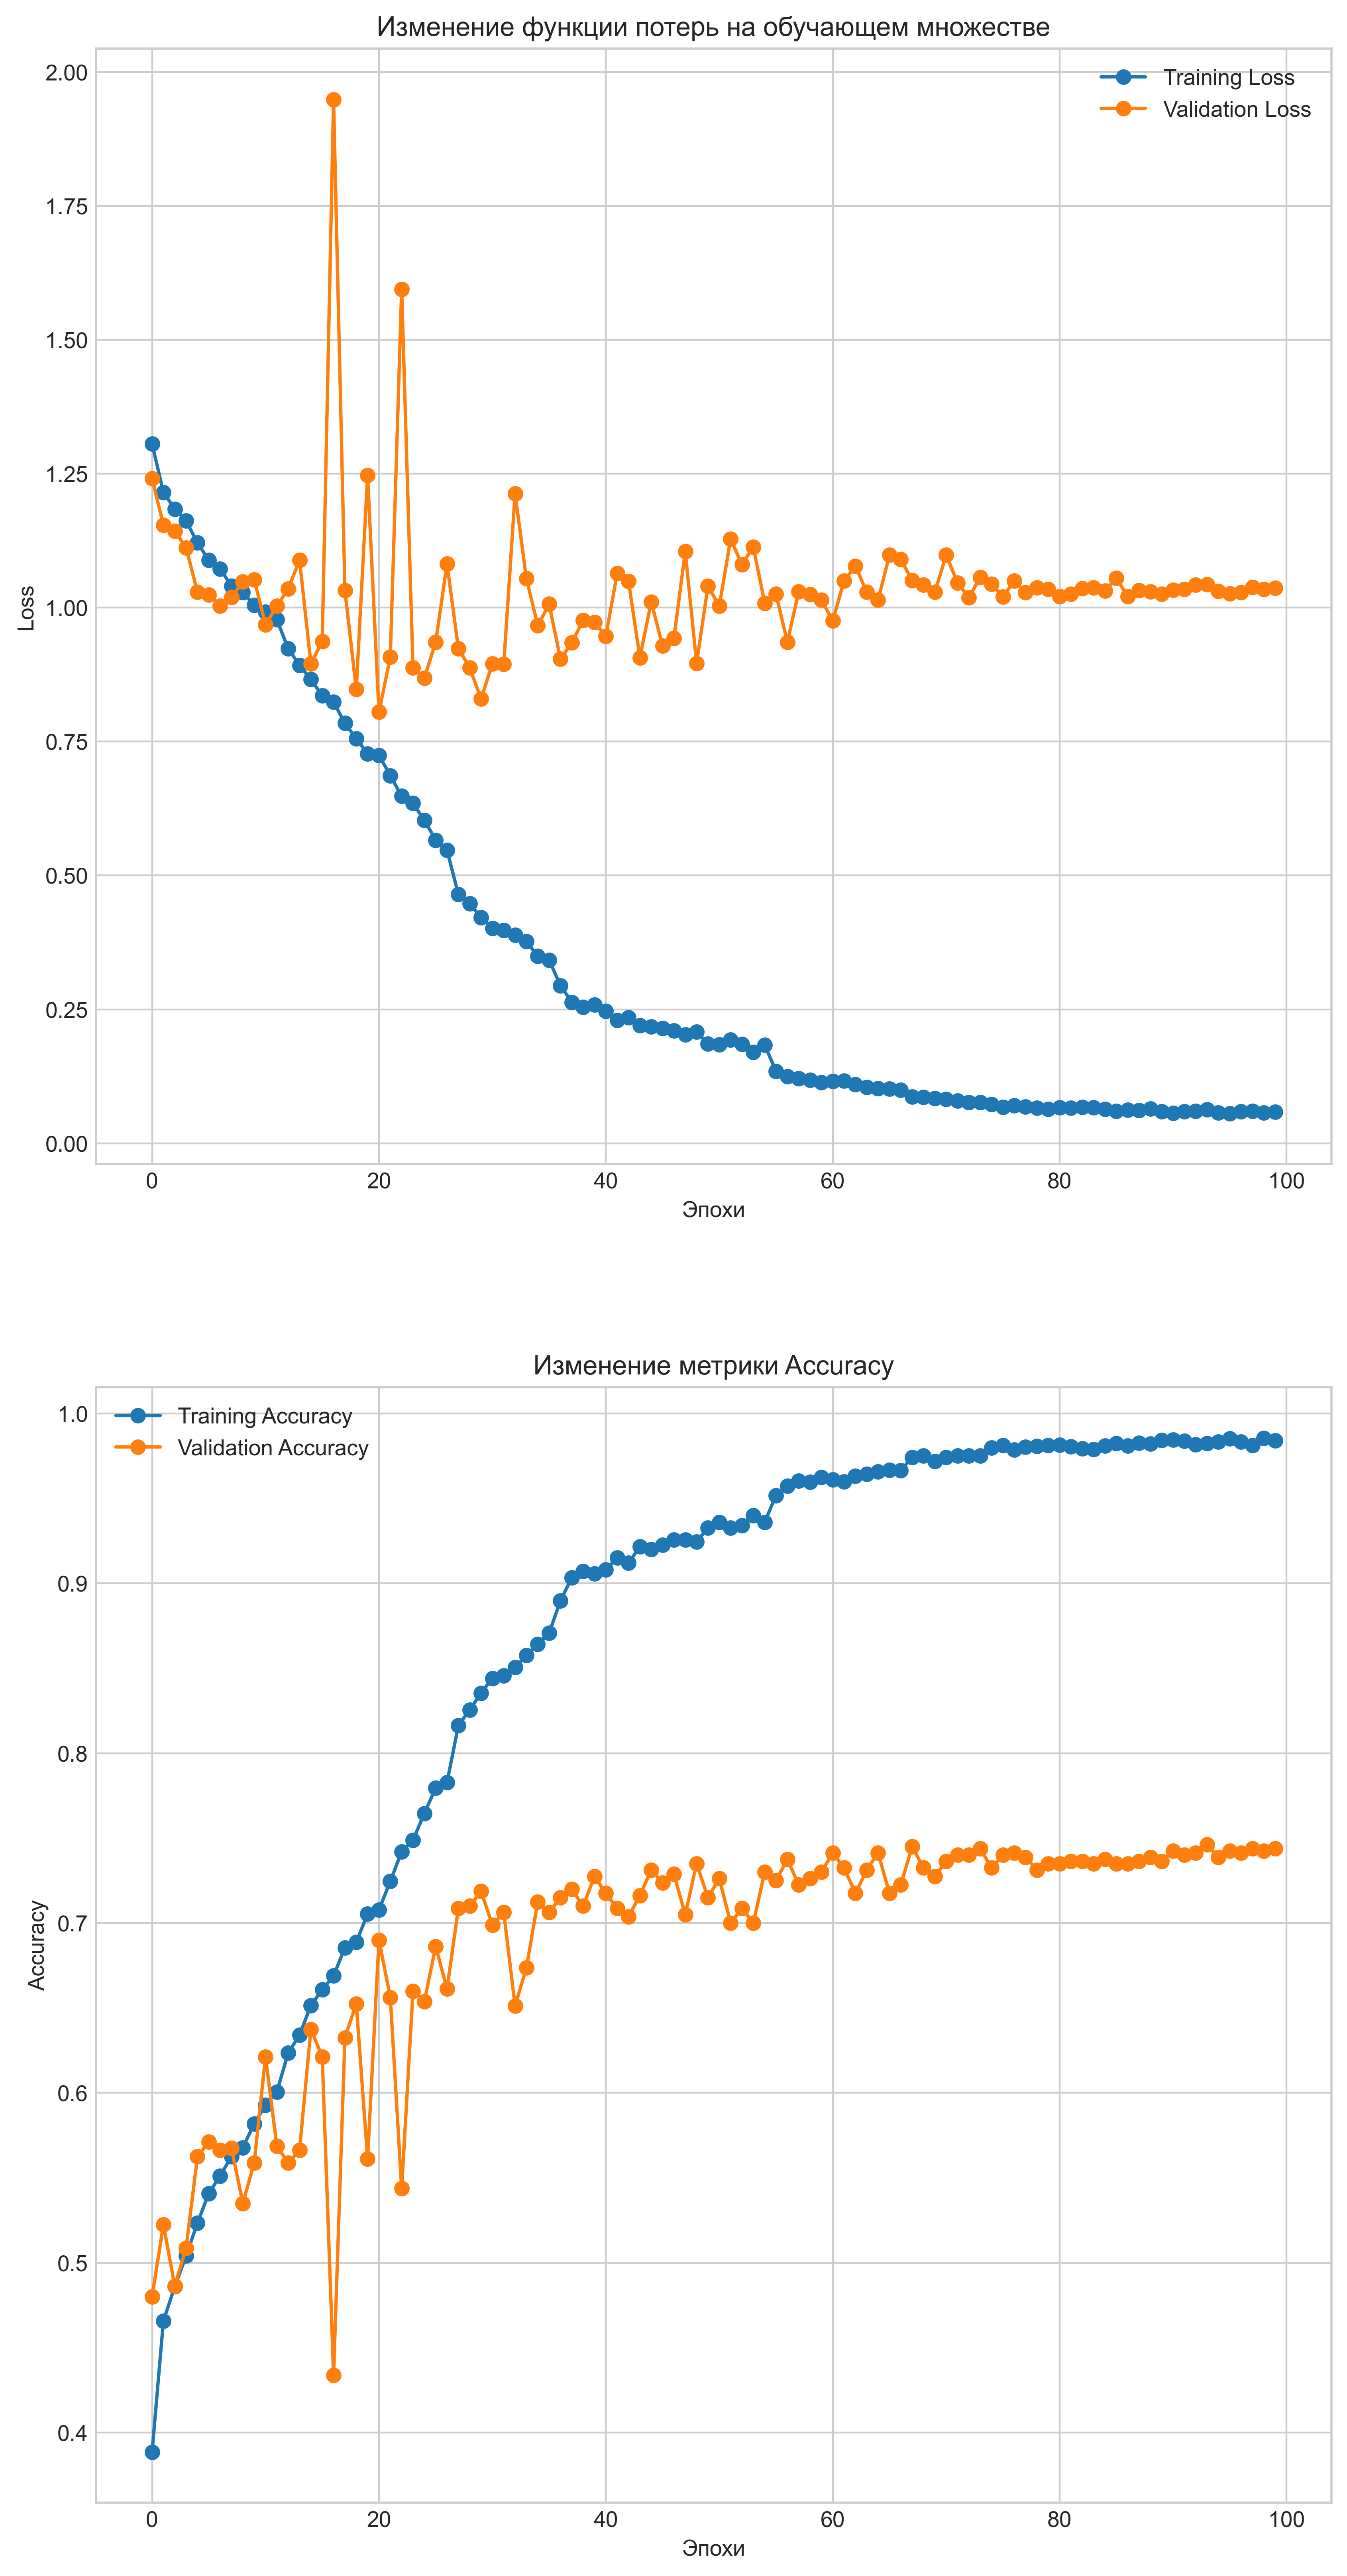


Примеры предсказаний CNN модели на случайных изображениях из тестового набора:


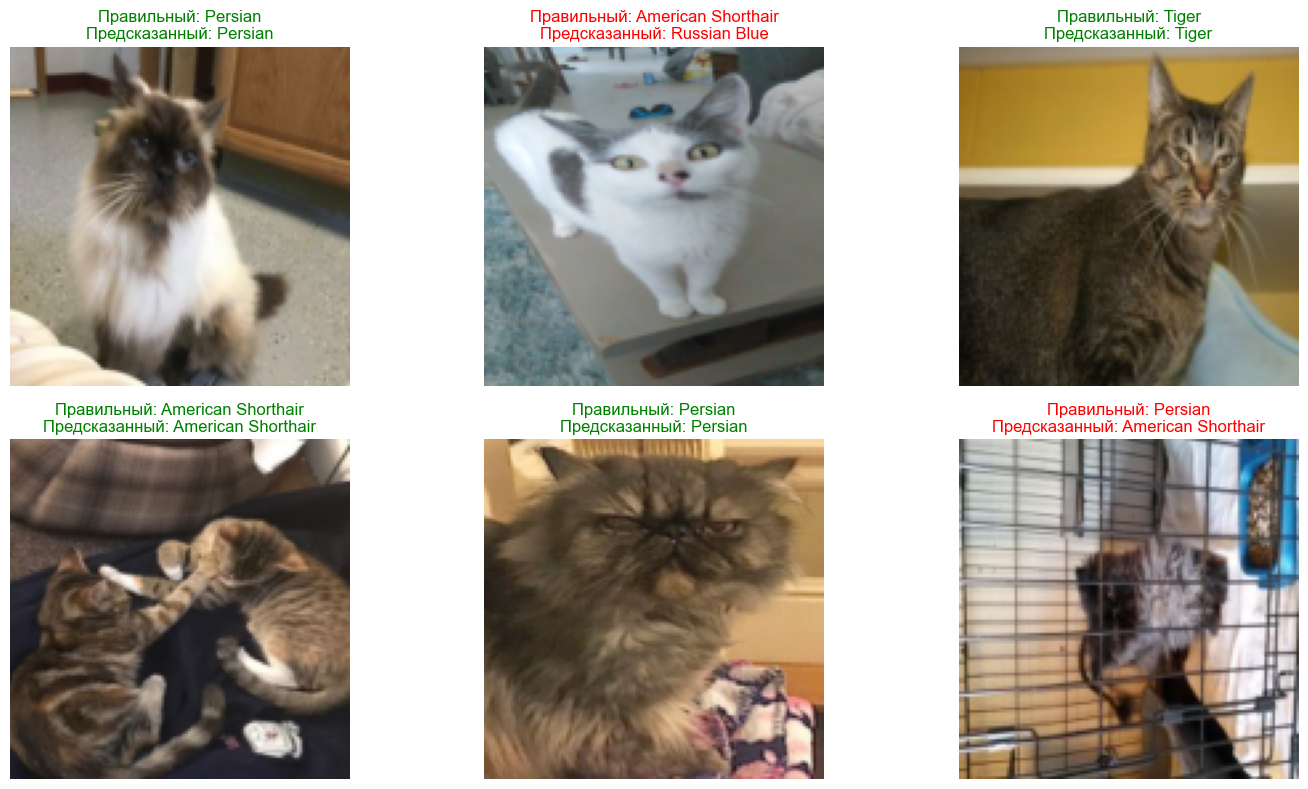

In [79]:
MAX_EPOCHS = 100
# learning_rate = 1e-3
learning_rate = 1e-2*2

zip_path = 'cat_breeds_4.zip'
data_path = 'cat_breeds_4'
dm = CatBreedsDataModule(data_path=data_path, zip_path=zip_path, batch_size=64, num_workers=15, )


dm.prepare_data()
dm.setup()
model_cnn = CNNClassifier(num_classes=dm.num_classes,learning_rate=learning_rate, class_weights= torch.tensor([0.25,0.25,0.25,0.25]))

# total_params_cnn = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
# print(f"Количество обучаемых параметров в CNN модели: {total_1params_cnn:,}")

checkpoint_callback = ModelCheckpoint(
    dirpath=OUT_DIR,
    filename="cnn_cats_03_1-{epoch:02d}-{val_acc:.4f}",
    save_top_k=1,
    monitor="val_acc",
    mode="max"
)
# early_stop_callback = EarlyStopping(
#     monitor='val_acc',
#     patience=10,    
#     verbose=True,
#     mode='max'      
# )

# TQDMProgressBar(refresh_rate=5)
trainer_cnn = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator="auto", callbacks=[checkpoint_callback]) #, early_stop_callback])
trainer_cnn.fit(model_cnn,train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.test_dataloader())
show_lossacc(model_cnn, annotate=False)

print("\nПримеры предсказаний CNN модели на случайных изображениях из тестового набора:")
mean_val = None
std_val = None
for transform in dm.transform.transforms:
    if isinstance(transform, T.Normalize):
        mean_val = transform.mean
        std_val = transform.std
        break

show_examples(model_cnn, dm.test_dataset, dm.class_names, mean=mean_val, std=std_val, k=6)

In [ ]:
random_state = 661

In [ ]:
val_loss=0.7462499737739563

<p class="task" id="5"></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

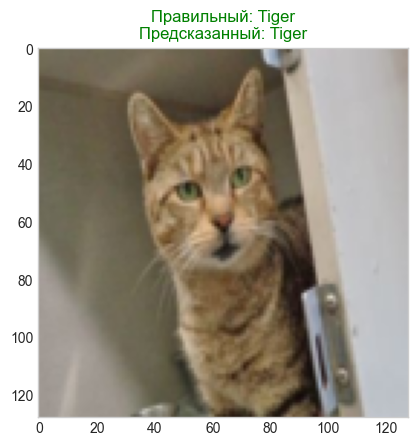

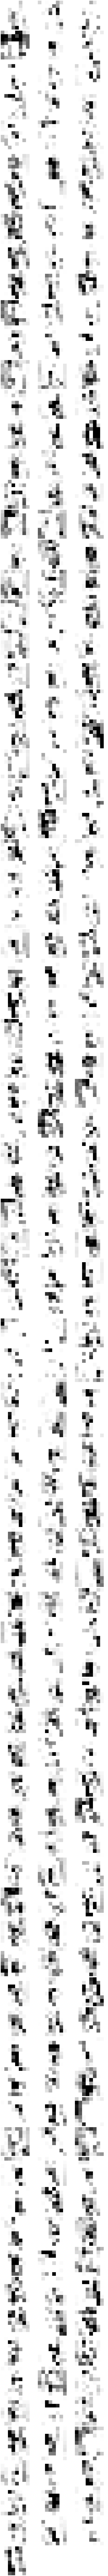

In [80]:
mean_val = None
std_val = None
for transform in dm.transform.transforms:
    if isinstance(transform, T.Normalize):
        mean = transform.mean
        std = transform.std
        break

std_tensor = torch.tensor(std).view(3, 1, 1)
mean_tensor = torch.tensor(mean).view(3, 1, 1)



curr = dm.test_dataset[np.random.choice(dm.test_dataset.__len__(),1)[0]]

image, label_idx = curr

logits = model_cnn(image.unsqueeze(0))
pred_idx = torch.argmax(logits, dim=1).item()

image_unnormalized = image * std_tensor + mean_tensor

image_to_show = image_unnormalized.permute(1, 2, 0).numpy()

image_to_show = np.clip(image_to_show, 0, 1)

true_class = dm.class_names[label_idx]
pred_class = dm.class_names[pred_idx]

plt.imshow(image_to_show)
plt.title(f"Правильный: {true_class}\nПредсказанный: {pred_class}", 
                color="green" if true_class == pred_class else "red")
plt.grid(False)
plt.show()



features =  np.clip(model_cnn.feature_extractor(image.unsqueeze(0))[0].permute(1, 2, 0).detach().numpy(), 0, 1)

k = features.shape[2]
rows = (k + 2) // 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

std_tensor = torch.tensor(std).view(3, 1, 1)
mean_tensor = torch.tensor(mean).view(3, 1, 1)

with torch.no_grad():
    for i in range(k):      
        ax = axes[i]
        ax.imshow(features[:,:,i])
        ax.axis('off')
        
for i in range(k, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()